# Use Sagemaker to use Optimization Libraries
We will test ecerithing using a local endpoint and will use SKLearn container as starting point to run optimization algorithm.  
The first step is to set-up the evironment importing required libraries and defining a bucket to host our model data.

In [2]:
import boto3
import numpy as np
import sagemaker

from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = "blogpost_location_service"

my_session = boto3.session.Session()
my_region = my_session.region_name

## Build a Sagemaker Model based on SKLearn
To test the algorithm we will use a standard SKLearn container providing information about the script that we would like to run (scripts-or-tools/algorithm.py) and additional libraries that shall be installed in order to be able to execute the script (scripts-or-tools/requirements.txt).
The key part of our script are:
- **__main__** - this is run during the training phase
- **model_fn** - executed during endpoint deployment start-up phase to load weight related to trained model
- **input_fn** - executed everitime inference method is invoked to adapt input data format to expected model format
- **predict_fn** - executes the inference here we use or-tools library in order to solve our Capacity Constrained Vehicle Routing Problem
- **output_fn** - executed right after the inference to adapt inference output data to expected output format that shall be returned to the caller.  
  
In this specific example since the optimization algorithm doesn't need a training phase we fill in the main function to generate dummy training data and the model_fn fucntion to load dummy training data.

Below you can see the detailed content of algorithm.py

In [3]:
!cat scripts-or-tools/algorithm.py

from __future__ import print_function

import csv
import json
import numpy as np
import pandas as pd
import boto3

import os
import argparse

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

from sagemaker_containers.beta.framework import (
    content_types, encoders, env, modules, transformer, worker)
    

    
#####
#Sagemaker interface
#####
def model_fn (model_dir):
    print ("ModelFN")
    return ("DUMMY MODEL")

def input_fn(input_data, content_type):
    """Parse input data payload

    We currently only take csv input. Since we need to process both labelled
    and unlabelled data we first determine whether the label column is present
    by looking at how many columns were provided.
    """
    print ("InputFN")
    print ("content_type:",content_type)
    print ("input_data:",input_data)
    if content_type == 'application/json':
        # Read the raw input data as CSV.
        list=json.loads(input_data)
        #Cat

We can build a dummi model.tar.gz locally, save it in an s3 bucket and use this one to build our SKLearn model.

In [4]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
!rm model.tar.gz
!touch dummy.ok; tar -czvf model.tar.gz ./dummy.ok
!aws s3 cp model.tar.gz s3://{bucket}/{prefix}/{timestamp}/model.tar.gz
print (f"Data saved to: s3://{bucket}/{prefix}/{timestamp}")

./dummy.ok
upload: ./model.tar.gz to s3://sagemaker-eu-west-1-113878695749/blogpost_location_service/20221021-155050/model.tar.gz
Data saved to: s3://sagemaker-eu-west-1-113878695749/blogpost_location_service/20221021-155050


We are now ready to use SKLearnModel passing information about our local scripts and dummy model.tar.gz file. 

In [5]:
from  sagemaker.sklearn.model import SKLearnModel
modelName=f"RouteOptimiser-{timestamp}"
sklearn_preprocessor = SKLearnModel(
    role=role,
    predictor_cls  = sagemaker.predictor.Predictor,
    sagemaker_session = sagemaker_session,
    name=modelName,
    model_data=f"s3://{bucket}/{prefix}/{timestamp}/model.tar.gz",
    source_dir = 'scripts-or-tools',
    entry_point= 'algorithm.py',
    framework_version ='0.23-1'
)

## Model Deploy
We can now deploy our model to accepts json as input and output format on a serverless endpoint defining a serverless inference config in order to specify the memory that should be allocated to run our optimization algorithm and a maximum concurrency.

In [6]:
from sagemaker.serverless import ServerlessInferenceConfig
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# Create an empty ServerlessInferenceConfig object to use default values
serverless_config =  ServerlessInferenceConfig(
          memory_size_in_mb=4096,
          max_concurrency=10)

predictor=sklearn_preprocessor.deploy(
    serverless_inference_config=serverless_config,
    serializer=JSONSerializer(content_type='application/json'),
    deserializer=JSONDeserializer(accept='application/json'))


-----!

## Now we are Ready for Testing
To run a full test of the optimization algorithm we would like to start from some ponts on a map, I select for this test some points in a area of Rome full of oneway streets to see which is the result.

In order to be able to use location services we need to retrieve the name of the instances that cloudformation has created for us.
Please configure the name of the cloudformation template you executed to set-up the environmetn

In [8]:
import time
cf=boto3.client ('cloudformation')
stackName='LocationServiceDemo'
response = cf.describe_stacks( StackName=stackName) 

while response['Stacks'][0]['StackStatus'] == 'CREATE_IN_PROGRESS':
    time.sleep(10)
    response = cf.describe_stacks( StackName=stackName) 
    print (response['Stacks'][0]['StackStatus'])
response['Stacks'][0]['StackStatus']   

'CREATE_COMPLETE'

In [9]:
for output in response['Stacks'][0]['Outputs']:
    if output['OutputKey']=='CalculatorName':
        locationCalculatorName=output['OutputValue']
    if output['OutputKey']=='MapName':
        locationMapName=output['OutputValue']

Define a list of points, the first is the starting and the ending point of te garbage collection route, the other points are where garbage bins are located

In [10]:
PointOfInterest=[
    [12.461333,41.906652 ], #via Properzio -oneway
    [12.462247,41.906664 ], #via Tibullo - oneway
    [12.463036,41.906764 ], #via Terenzio - oneway
    [12.460591,41.906862 ]  #via Cola Di Rienzo 2-ways
]

Generate Route Matrix to be used by optimization algorith leveraging AWS Location Services.
Set-up contrstaints in order to be able to find routes allowed for garbage trucks (size and weight).

In [12]:
location=boto3.client('location')
response=location.calculate_route_matrix(
  CalculatorName= locationCalculatorName,
  DepartNow= True,
  DistanceUnit= "Kilometers",
  TravelMode= "Truck",
  TruckModeOptions= {
    'AvoidFerries': True,
    'AvoidTolls': True,
    'Dimensions': {
      'Height': 3.5,
      'Length': 4.95,
      'Unit': "Meters",
      'Width': 1.9,
    },
    'Weight': {
      'Total': 4500,
      'Unit': "Kilograms",
    },
   },
  DeparturePositions=PointOfInterest,
  DestinationPositions=PointOfInterest)


Fill in the Distance matrix with the information returned by Amazon Location service calculate_route_matrix and store in a numpy matrix

In [13]:
DistanceMatrix=np.zeros((len(response['RouteMatrix']),len(response['RouteMatrix'][0])))
for i in range (0,len(response['RouteMatrix'])):
    for j in range (0,len(response['RouteMatrix'][i])):
        DistanceMatrix[i][j]=response['RouteMatrix'][i][j]['Distance']
        
DistanceMatrix

array([[0.   , 0.812, 0.731, 0.679],
       [0.824, 0.   , 0.674, 0.622],
       [0.787, 0.718, 0.   , 0.263],
       [0.88 , 0.837, 0.756, 0.   ]])

Distance Matrix is Asymmetric to reflect that some points are in one-way roads. 

## Prepare data for Optimization Algorithm
Prepare data structure to submit problem to solver:
- distance_matrix contains the distance matrix
- num_vehicles contains the number of trucks I can have to collect trash
- depot is the item in the instance matrix that is the depot (start and end point of the trash collection cycle)
- vehicle_capacities is an array that specify the capacity (number of trash bins that can be collected before the truck becomes full) for each truck in the fleet


In [14]:
%%time
data = {}
data['distance_matrix'] = DistanceMatrix.tolist()
data['num_vehicles'] = 1
data['depot'] = 0
data['vehicle_capacities']=[20]



CPU times: user 15 ms, sys: 15 µs, total: 15 ms
Wall time: 16.6 s


[[0, 3, 2, 1, 0]]

Now we are ready to call the solver

In [24]:
prediction_result=predictor.predict (data)

prediction_result

[[0, 3, 2, 1, 0]]

Result contains an ordered list of the edges that the truck has to go through.
Now we want to convert back edge indexes to geo referenced points

In [15]:
optimized_path=prediction_result[0]
WayPoints=[]
#loop on points skipping first and last
for i in range (1,len(optimized_path)-1):
    WayPoints.append(PointOfInterest[optimized_path[i]])
    
WayPoints    

[[12.460591, 41.906862], [12.463036, 41.906764], [12.462247, 41.906664]]

## Plot route on a map

Use AWS Location service to extract routes details used to draw the route on a map leveraing IncludeLegGeometry feature available in Amazon Location Service calculate_route method. 

We provede start and end route points and all trash bin point in the same order as returned by the optimization algorithm. 
We also provide additional informatin about the type of vehicle ("Truck") and its size in order to retrieve the correct path and avoid ruoutes that are not matching this requirement.

In [17]:
response = location.calculate_route(
    CalculatorName= locationCalculatorName,
    DepartNow=True,
    DeparturePosition=PointOfInterest[optimized_path[0]],  #Start and Endpoint are the same
    DestinationPosition=PointOfInterest[optimized_path[0]],
    DistanceUnit='Kilometers',
    IncludeLegGeometry=True,  # Ask location services to break down the route in segmets that can be easily print on a map
   TravelMode='Truck',
    TruckModeOptions= {
   'AvoidFerries': True,
   'AvoidTolls': True,
   'Dimensions': {
     'Height': 3.5,
     'Length': 4.95,
     'Unit': "Meters",
     'Width': 1.9,
   },
   'Weight': {
     'Total': 4500,
     'Unit': "Kilograms",
   },
  },
    WaypointPositions=WayPoints  # Ordered list of the trash bin to be collected as returned by the optimizer
)

The response contains a Geometry element including the information about all legs buildling the full route.

In [18]:
response

{'ResponseMetadata': {'RequestId': '9a4947e7-70aa-44e6-b68e-7dff25f0df08',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 21 Oct 2022 16:14:55 GMT',
   'content-type': 'application/json',
   'content-length': '5693',
   'connection': 'keep-alive',
   'x-amzn-requestid': '9a4947e7-70aa-44e6-b68e-7dff25f0df08',
   'access-control-allow-origin': '*',
   'x-amz-apigw-id': 'aXPMBHJiDoEFRRg=',
   'access-control-expose-headers': 'x-amzn-errortype,x-amzn-requestid,x-amzn-errormessage,x-amzn-trace-id,x-amz-apigw-id,date',
   'x-amzn-trace-id': 'Root=1-6352c57f-10426ac201d6beda14d31cfc'},
  'RetryAttempts': 0},
 'Legs': [{'Distance': 0.679,
   'DurationSeconds': 230,
   'EndPosition': [12.4605994, 41.9068425],
   'Geometry': {'LineString': [[12.461333, 41.906652],
     [12.46137, 41.90703],
     [12.46179, 41.90714],
     [12.46229, 41.90726],
     [12.46278, 41.90738],
     [12.4633, 41.90751],
     [12.46394, 41.90767],
     [12.46419, 41.90715],
     [12.46368, 41.90705],
     [12.

Extract paths from the overall route to be able to render them on Map

In [19]:
path=[]
for leg in response['Legs']:
    path.append ([leg['StartPosition'][0],leg['StartPosition'][1]])
    for poi in leg['Geometry']['LineString']:
        path.append ([poi[0],poi[1]])
    


## Visualize the results.  

We will use IPython and Amazon Location Services to visualize the output leveraging a template html page that will load all the relevant javascript libraries, then we customize this teplate in order to add all the information data we would like to display, and then we use IFrame to render the generated html file.

In [22]:
from IPython.display import IFrame
import json

Zoom=16
 
#Transform python variables into json srtings
jsonPointOfInterest=json.dumps(PointOfInterest)
jsonOptimized_path=json.dumps(optimized_path)
jsonPath=json.dumps(path)
def get_credentials( role):
    sts_client = boto3.client("sts")

    role_arn = role
    role_session_name = "MAPS"

    resp = sts_client.assume_role(
        RoleArn=role_arn,
        RoleSessionName=role_session_name
    )

    return resp["Credentials"]

credentials=get_credentials(role)

jsonPointOfInterest=json.dumps(PointOfInterest)
jsonOptimized_path=json.dumps(optimized_path)
jsonPath=json.dumps (path)


with open ("./locationservice-pages/all-in-one.html_template") as template:
    html_template=template.read()
    
with open ("./locationservice-pages/all-in-one.html","w") as page:
    html_page=html_template.format(mapName=locationMapName,
                                   accessKeyId=credentials['AccessKeyId'],
                                   secretAccessKey=credentials['SecretAccessKey'],
                                   sessionToken=credentials['SessionToken'],
                                   center =json.dumps([PointOfInterest[optimized_path[0]][0],PointOfInterest[optimized_path[0]][1]]),
                                   jsonPointOfInterest=jsonPointOfInterest,
                                   jsonOptimized_path=jsonOptimized_path,
                                   jsonPath=jsonPath,
                                   region=my_region,
                                   zoom=Zoom
                                   )
    page.write(html_page)
    
IFrame(src='./locationservice-pages/all-in-one.html', width=800, height=500)

## Create an API endpoint to expose Inference endpoint to the front-end application.
The next step is related to create an API Gateway to expose the service to our font-end application, the API Gateway will call a lambda function that is interacting with location service to prepare the distance matrix and call Sagemaker endpoint to execute the inference.
Hereafter the name of the Sagemaker Endpoint to input in cloudformation template to build API Gateway and lambda components.

In [28]:
predictor.endpoint_name

'RouteOptimiser-20221021-155050-2022-10-21-15-50-56-575'

## Let's build our webapp
We are now ready to build our Web App leveraging amplify

In [ ]:
raise Exception ("Execute the following step after testing the web app.")

## Cleanup

Delete API Gateway, predictor endpoint and location service map and route calculator, sagemaker model and content of S3 bucket. 

In [ ]:
predictor.delete_endpoint()

In [ ]:
!aws sagemaker delete-model --model-name {modelName}

In [ ]:
!aws s3 rm s3://{bucket}/{prefix} --recursive

You can now click on "Running Terminals and Kernels" on the left of the screen and terminate the instance running this notebook to avoid incurring in unexpected costs.

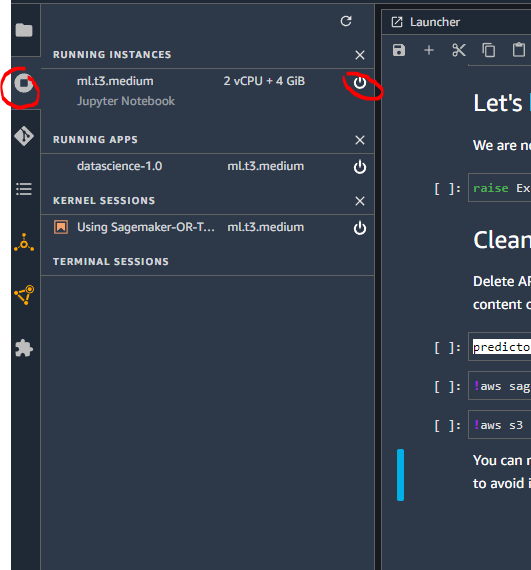